1、加载图像

第一种，把图片看做是一个图片直接读进来，获取图片的原始数据，再进行解码。如使用tf.gfile.FastGFile()读取图像文件，然后，利用tf.image.decode_jpeg()或tf.image.decode_pgn()进行解码。示例代码如下

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


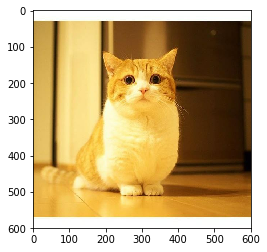

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
  
%matplotlib inline 

image_raw_data_jpg = tf.gfile.FastGFile('./image/cat/cat.jpg', 'rb').read()  
  
with tf.Session() as sess:  
    img_data = tf.image.decode_jpeg(image_raw_data_jpg) #图像解码  
      
    plt.figure(1) #图像显示  
    print(sess.run(img_data))#显示图像矩阵
    plt.imshow(img_data.eval()) #显示图像


第一种方法不太适合读取批量数据，批量读取可以采用另一种方法，这种方法把图像看成一个文件，用队列的方式读取。在TensorFlow中，队列不仅是一种数据结构，更提供了多线程机制。首先，使用tf.train.string_input_producer找到所需文件，并将其加载到一个队列中，然后，使用tf.WholeFileReader()把完整的文件加载到内存中，用read从队列中读取图像文件，最后，用tf.image.decode_jpeg()或tf.image.decode_pgn()进行解码。以下为代码示例。

In [2]:
import tensorflow as tf 
  
path = './image/cat/cat.jpg'  
file_queue = tf.train.string_input_producer([path]) #创建输入队列  
image_reader = tf.WholeFileReader()  
_, image = image_reader.read(file_queue)  
image = tf.image.decode_jpeg(image)  
  
with tf.Session() as sess:  
    coord = tf.train.Coordinator() #协同启动的线程  
    threads = tf.train.start_queue_runners(sess=sess, coord=coord) #启动线程运行队列  
    print(sess.run(image)) 
    coord.request_stop() #停止所有的线程  
    coord.join(threads) 


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


2、把图像转换为TFRecord文件

In [7]:
# -*- coding: utf-8 -*-
import os
import tensorflow as tf
from PIL import Image #处理图像的包 
import numpy as np


folder='./image/'
#设定图像类别标签标签，标签名称和对应子目录名相同
label={'cat','dog'}
#要生成的文件
writer= tf.python_io.TFRecordWriter(folder+'cat_dog.tfrecords')
#记录图像的个数
count=0
for index,name in enumerate(label):
    folder_path=folder+name+'/'
    for img_name in os.listdir(folder_path):
        img_path=folder_path+img_name #每一个图片的完整访问路径
        img=Image.open(img_path)
        img= img.resize((128,128))
        img_raw=img.tobytes()#将图片转化为二进制格式
        example = tf.train.Example(features=tf.train.Features(feature={
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
            'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
        })) #example对象对label和image数据进行封装
        writer.write(example.SerializeToString())  #序列化为字符串
        count=count+1
writer.close()


3、读取TFRecord文件

In [9]:
#定义数据流队列
filename_queue = tf.train.string_input_producer([folder+'cat_dog.tfrecords']) 
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)   #返回文件名和文件
features = tf.parse_single_example(serialized_example,
                                   features={
                                       'label': tf.FixedLenFeature([], tf.int64),
                                       'img_raw' : tf.FixedLenFeature([], tf.string),
})#取出包含image和label的feature对象
image = tf.decode_raw(features['img_raw'], tf.uint8)
image = tf.reshape(image, [128, 128, 3])
label = tf.cast(features['label'], tf.int32)
with tf.Session() as sess: #开始一个会话
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    coord=tf.train.Coordinator()
    #线程协调器
    threads= tf.train.start_queue_runners(coord=coord)
    #以多线程的方式启动对队列的处理
    for i in range(count):
        example, l = sess.run([image,label])#在会话中取出image和label
        img=Image.fromarray(example, 'RGB')#是from PIL import Image 的引用
        img.save(folder +str(i)+'_Label_'+str(l)+'.jpg')#存下图片
        print(example, l)
    coord.request_stop()#请求停止线程
    coord.join(threads)    #等待所有进程结束


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[[148 156 158]
  [134 142 144]
  [125 131 131]
  ..., 
  [ 15  24  21]
  [ 17  26  23]
  [ 18  27  24]]

 [[149 157 159]
  [135 143 145]
  [126 132 132]
  ..., 
  [ 19  28  25]
  [ 20  29  26]
  [ 22  31  28]]

 [[154 162 164]
  [139 147 149]
  [129 135 135]
  ..., 
  [ 22  31  28]
  [ 22  31  28]
  [ 23  32  29]]

 ..., 
 [[146 151 154]
  [132 137 140]
  [119 123 124]
  ..., 
  [ 15  24  21]
  [ 13  22  19]
  [ 16  25  22]]

 [[147 152 155]
  [132 137 140]
  [121 125 126]
  ..., 
  [ 15  24  21]
  [ 13  22  19]
  [ 17  26  23]]

 [[140 145 148]
  [126 131 134]
  [115 119 120]
  ..., 
  [ 18  27  24]
  [ 17  26  23]
  [ 21  30  27]]] 0
[[[142 143 137]
  [145 146 140]
  [148 149 141]
  ..., 
  [149 150 119]
  [149 150 118]
  [147 148 114]]

 [[142 143 135]
  [142 143 135]
  [142 143 135]
  ..., 
  [146 146 120]
  [145 145 117]
  [143 143 115]]

 [[139 140 132]
  [136 138 127]
  [134 136 125]
  ..., 
  [142 143 12

4、图像处理实例

下面例子给出了一些常见图像处理方法，包括调整大小、剪裁和填充、色彩调整等。代码基于一个600*600大小的猫的图像，如下图所示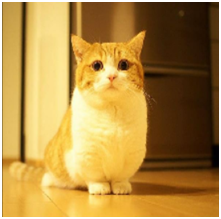

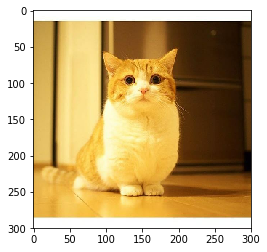

In [19]:
#调整图像大小    
# -*- coding: utf-8 -*-
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf   
import numpy as np
import os

os.getcwd()
image_raw_data = tf.gfile.FastGFile('./cat.jpeg','rb').read()

img_data = tf.image.decode_jpeg(image_raw_data)

with tf.Session() as sess: 
    resized = tf.image.resize_images(img_data, [300, 300], method=0)
    cat = np.asarray(resized.eval(), dtype='uint8')
    plt.imshow(cat)
    plt.show()    


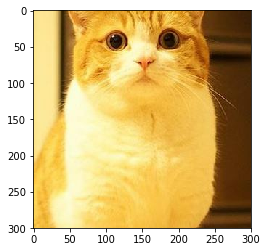

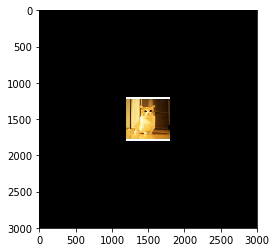

In [20]:
#裁剪和填充图像
with tf.Session() as sess:    
    croped = tf.image.resize_image_with_crop_or_pad(img_data, 300, 300)
    padded = tf.image.resize_image_with_crop_or_pad(img_data, 3000, 3000)
    plt.imshow(croped.eval())
    plt.show()
    plt.imshow(padded.eval())
    plt.show()    


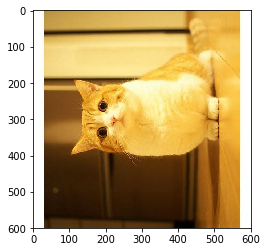

In [21]:
#对角线翻转图像
with tf.Session() as sess:
    transposed = tf.image.transpose_image(img_data)
    plt.imshow(transposed.eval())
    plt.show()


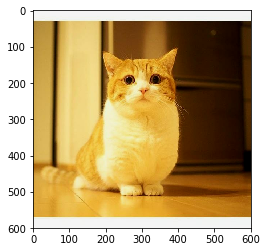

In [22]:
#图像色彩调整    
with tf.Session() as sess:     
    # 在[-max_delta, max_delta)的范围随机调整图片的亮度。
    adjusted = tf.image.random_brightness(img_data, max_delta=0.5)
    plt.imshow(adjusted.eval())
    plt.show() 


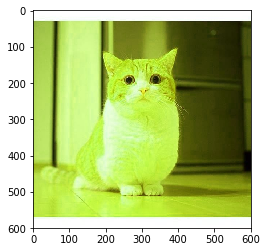

In [24]:
#调整图像色调饱和度    
with tf.Session() as sess:         
    adjusted = tf.image.adjust_hue(img_data, 0.1)
    plt.imshow(adjusted.eval())
    plt.show()   


5、全新的数据读取方式Dataset API

利用tf.data.Dataset.from_tensor_slices()从一或多个tf.Tensor对象中构建一个dataset

In [25]:
import tensorflow as tf
import numpy as np

arry1=np.array([1.0, 2.0, 3.0, 4.0, 5.0])
dataset = tf.data.Dataset.from_tensor_slices(arry1)
#生成实例
iterator = dataset.make_one_shot_iterator()
#从iterator里取出一个元素
one_element = iterator.get_next()
with tf.Session() as sess:
   for i in range(len(arry1)):
       print(sess.run(one_element))


1.0
2.0
3.0
4.0
5.0


Dataset的转换（transformations）

（1）使用map()

In [ ]:
import tensorflow as tf
import numpy as np

a1=np.array([1.0, 2.0, 3.0, 4.0, 5.0])
dataset = tf.data.Dataset.from_tensor_slices(a1)
dataset = dataset.map(lambda x: x * 2) # 2.0, 3.0, 4.0, 5.0, 6.0
iterator = dataset.make_one_shot_iterator()
#从iterator里取出一个元素
one_element = iterator.get_next()
with tf.Session() as sess:
   for i in range(len(a1)):
       print(sess.run(one_element))


（2）使用flat_map()、filter()等，样例代码，请勿执行！

In [30]:
#使用‘Dataset.flat_map（）’将每个文件转换为一个单独的嵌套数据集
#然后将它们的内容顺序连接成一个单一的“扁平”数据集
#跳过第一行（标题行）
#过滤以“＃”开头的行

filenames = ["/var/data/file1.txt", "/var/data/file2.txt"]

dataset = tf.data.Dataset.from_tensor_slices(filenames)

dataset = dataset.flat_map(
    lambda filename: (
        tf.data.TextLineDataset(filename)
        .skip(1)
        .filter(lambda line: tf.not_equal(tf.substr(line, 0, 1), "#"))))


（3）batch()、shuffle()、repeat()

In [31]:
filenames = ["/var/data/file1.tfrecord", "/var/data/file2.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(32)
dataset = dataset.repeat(4)


 tf.data.TextLineDataset()

很多数据集是一个或多个文本文件，tf.data.TextLineDataset提供了一种简单的方式来提取这些文件的每一行，以下为样例代码，请勿执行。

In [32]:
filenames = ["/var/data/file1.txt", "/var/data/file2.txt"]
dataset = tf.data.TextLineDataset(filenames)


In [33]:
filenames = ["/var/data/file1.txt", "/var/data/file2.txt"]
dataset = tf.data.Dataset.from_tensor_slices(filenames)
# 使用Dataset.flat_map()把文件转换为一个dataset,
# 连接各文件并转换为一个 "flat" dataset.
# 跳过第一行.
# 过滤以 "#" 开头的行，即注释行.
dataset = dataset.flat_map(
    lambda filename: (
        tf.data.TextLineDataset(filename)
        .skip(1)
        .filter(lambda line: tf.not_equal(tf.substr(line, 0, 1), "#"))))


tf.data.TFRecordDataset()

TFRecord是一种面向记录的二进制文件，很多TensorFlow应用使用它作为训练数据。tf.contrib.data.TFRecordDataset能够使TFRecord文件作为输入管道的输入流，以下是样例代码，请勿执行：

In [34]:
filenames = ["/var/data/file1.tfrecord", "/var/data/file2.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)


In [37]:
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
iterator = dataset.make_initializable_iterator()

training_filenames = ["/var/data/file1.tfrecord", "/var/data/file2.tfrecord"]
with tf.Session() as sess:
    sess.run(iterator.initializer, feed_dict={filenames: training_filenames})
    #Initialize `iterator` with validation data.
    validation_filenames = ["/var/data/validation1.tfrecord"]
    sess.run(iterator.initializer, feed_dict={filenames: validation_filenames})


创建迭代器

In [52]:
dataset = tf.data.Dataset.range(100)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
sess=tf.Session()
for i in range(100):
  value = sess.run(next_element)
  assert i == value
#initializable迭代器需要在使用前进行iterator.initializer的操作，虽然不方便，但支持参数化，可以使用一个或多个 tf.placeholder() 在初始化迭代器时占位：
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()


从迭代器中获取数据

从迭代器中获取数据可以使用 Iterator.get_next() 方法。当迭代器到达dataset尾部时，运行Iterator.get_next() 会raise一个tf.errors.OutOfRangeError。这个迭代器就处于不可用状态，必须重新初始化才可以使用。




In [57]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"


0
2
4
6
8
End of dataset


读入输入数据

以下为读取Numpy数组示例（样例代码，请勿执行）。用tf.placeholder() 张量来定义Dataset ，并在迭代器初始化时，把Numpy数组feed进去。

In [ ]:
# 假设特征和标签在同一行.
assert features.shape[0] == labels.shape[0]

features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
iterator = dataset.make_initializable_iterator()
sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})



预处理数据，样例代码，请勿执行

In [ ]:
import cv2
#使用自定义的OpenCV函数读取图像，
#而不是标准的TensorFlow`tf.read_file（）`操作。
def _read_py_function(filename, label):
  image_decoded = cv2.imread(filename.decode(), cv2.IMREAD_GRAYSCALE)
  return image_decoded, label

#使用标准的TensorFlow操作将图像调整为固定形状。
def _resize_function(image_decoded, label):
  image_decoded.set_shape([None, None, None])
  image_resized = tf.image.resize_images(image_decoded, [28, 28])
  return image_resized, label

filenames = ["/var/data/image1.jpg", "/var/data/image2.jpg", ...]
labels = [0, 37, 29, 1, ...]

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.map(
    lambda filename, label: tuple(tf.py_func(
        _read_py_function, [filename, label], [tf.uint8, label.dtype])))
dataset = dataset.map(_resize_function)


批处理数据集元素

简单批处理的方法适用于相同大小的张量。然而很多模型的输入数据大小不同，Dataset.padded_batch() 操作可以通过指定填充它们的一个或多个尺寸来批量处理不同形状的张量。示例代码如下：

In [ ]:
#样例代码，请勿执行
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=[None])

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

print(sess.run(next_element))  
print(sess.run(next_element))  

随机切割输入数据（样例代码，请勿执行）

In [ ]:
filenames = ["/var/data/file1.tfrecord", "/var/data/file2.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(...)
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(32)
dataset = dataset.repeat()


使用高级API，样例代码，请勿执行

In [ ]:
def dataset_input_fn():
  filenames = ["/var/data/file1.tfrecord", "/var/data/file2.tfrecord"]
  dataset = tf.data.TFRecordDataset(filenames)

  # 使用tf.parse_single_example()从tf.Example中抽取数据
  # protocol buffer, and perform any additional per-record preprocessing.
  def parser(record):
    keys_to_features = {
        "image_data": tf.FixedLenFeature((), tf.string, default_value=""),
        "date_time": tf.FixedLenFeature((), tf.int64, default_value=""),
        "label": tf.FixedLenFeature((), tf.int64,
                                    default_value=tf.zeros([], dtype=tf.int64)),
    }
    parsed = tf.parse_single_example(record, keys_to_features)

    # 执行预处理.
    image = tf.image.decode_jpeg(parsed["image_data"])
    image = tf.reshape(image, [299, 299, 1])
    label = tf.cast(parsed["label"], tf.int32)

    return {"image_data": image, "date_time": parsed["date_time"]}, label

  # 使用Dataset.map()构建一个包含特征及标签的数据字典
  dataset = dataset.map(parser)
  dataset = dataset.shuffle(buffer_size=10000)
  dataset = dataset.batch(32)
  dataset = dataset.repeat(num_epochs)
  iterator = dataset.make_one_shot_iterator()

  features, labels = iterator.get_next()
  return features, labels
